# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [29]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preparation

In [4]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [5]:
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")
X_data.head()

There is 78 dimensions.


,2,3,4,5,6,7,8,9,10,11,...,70,71,72,73,74,75,76,77,78,79
0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,0.079785,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,0.471188,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,1.046599,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,0.432868,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,0.824695,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [6]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [7]:
# Showing that there is empty columns (with null std).
small_std = []
stdX = X_data.std()
for i in range(78):
    if stdX.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
X_data.iloc[:,small_std].describe()

[46, 47, 48, 49, 50]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [8]:
# Removing columns with null std
X_data = X_data.loc[:, (X_data.std() > 1e-6)]
dim_notebook = len(X_data.columns)
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 73 dimensions.


In [9]:
#Data normalisation
X_data = scale(X_data)

In [10]:
Y_data = Y_data.replace([0], -1)
print(Y_data.size)
Y_data.head()

50000


,state
0,-1
1,-1
2,1
3,-1
4,-1


In [11]:
Y_data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

## Handling IID data

In [12]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  5000
There is 10 devices.
torch.Size([5000, 74])


In [28]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 1")
for y in Y:
    print("ratio : ", (y == 1).sum().item() / (y == -1).sum().item())

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 1
ratio :  0.9801980198019802
ratio :  0.9623233908948194
ratio :  1.0267531414673692
ratio :  0.9577133907595928
ratio :  1.044153720359771
ratio :  0.9546520719311963
ratio :  1.0064205457463884
ratio :  0.9849146486701071
ratio :  0.9731649565903709
ratio :  1.0032051282051282


In [11]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=LogisticModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-iid-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

Large dimension...
   it    |   obj   
    4000 | 5.4296e-01
    8000 | 5.4296e-01
   12000 | 5.4296e-01
   16000 | 5.4296e-01


100%|██████████| 1/1 [08:23<00:00, 503.40s/it]

Gradient Descent: execution time=503.287 seconds
Final loss :  0.5429626320415096

CPU times: user 52min 41s, sys: 8min 38s, total: 1h 1min 19s
Wall time: 8min 23s


In [14]:
id = 5
x = X[id]
w = obj_min_by_N_descent.model_params[-1]
mul = x.mv(w)
inf_middle = 0
failure = 0
for i in range(len(mul)):
    if torch.sigmoid(mul[i]) > 0.5:
        if Y[id][i] != 1:
            failure +=1
        inf_middle +=1
print("Number of labels equal to 1: ", inf_middle)
print("Failures:", failure)
print("Percent of labels wrongly predicted to be state 1: " + str(failure/inf_middle) + "%")

Number of labels equal to 1:  2420
Failures: 706
Percent of labels wrongly predicted to 1: 0.29173553719008266%


In [15]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = LogisticModel(), 
                                               use_averaging=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-iid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 20%|██        | 1/5 [18:11<1:12:44, 1091.11s/it]

QSGD
Large dimension...
Large dimension...


 40%|████      | 2/5 [1:04:13<1:19:37, 1592.35s/it]

Diana
Large dimension...
Large dimension...


 60%|██████    | 3/5 [1:58:31<1:09:44, 2092.20s/it]

BiQSGD
Large dimension...
Large dimension...


 80%|████████  | 4/5 [3:03:18<43:50, 2630.61s/it]  

Artemis
Large dimension...
Large dimension...


100%|██████████| 5/5 [3:56:30<00:00, 2838.06s/it]

CPU times: user 3h 42min 28s, sys: 3min 57s, total: 3h 46min 25s
Wall time: 3h 56min 30s


In [16]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

[tensor([-1.1781e-02,  1.3338e-02, -4.3104e-03,  2.7344e-03,  7.2330e-01,
         -4.9947e-03, -1.2229e-02, -2.3461e-02,  2.6931e-01,  1.3978e-02,
          3.3728e-03,  1.3182e-02, -5.1071e-02,  9.9566e-01,  4.5580e-01,
          1.6930e-01, -6.2584e-03, -2.4891e-02,  1.8266e-02,  1.8511e-03,
          8.1876e-03, -4.2639e-04,  1.0322e-05,  1.0468e-02,  5.9619e-03,
         -1.4086e-02,  3.8503e-02, -1.2435e-02,  1.0470e-02, -2.4352e-03,
         -1.5670e-02, -1.5337e-01,  1.2135e-02, -1.2872e-02,  6.4625e-03,
          2.4098e-02,  2.6801e-03, -4.5879e-03,  3.5006e-03, -2.6637e-02,
         -5.2663e-02, -2.0665e-02,  4.4454e-02, -2.4352e-03, -1.9099e-03,
         -1.8708e-03, -2.0379e-03,  4.2069e-03, -4.7397e-02, -2.2419e-02,
          4.2069e-03, -9.1931e-02, -1.4815e-02,  3.6984e-02,  5.0175e-02,
         -2.2456e-02,  1.6618e-02,  2.5132e-02,  1.1957e-01,  7.1387e-03,
         -1.3615e-02,  1.9028e-01,  7.7316e-03,  9.2358e-05, -1.5504e-01,
         -2.0472e-02,  3.2524e-01, -3.

# With averaging

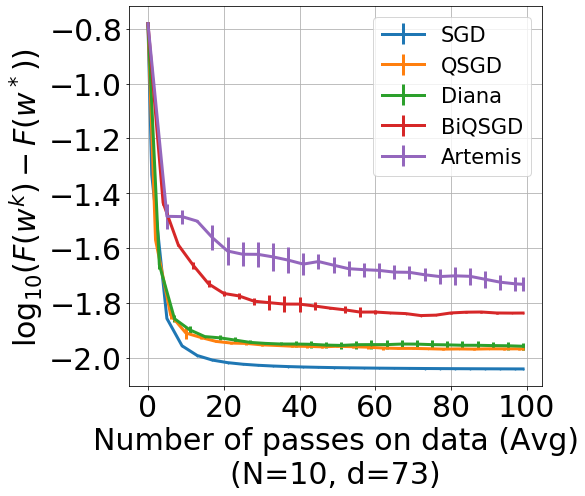

In [17]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")
obj = obj_min_by_N[len(myX)] - 0.009

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data\n(Avg, iid)") 

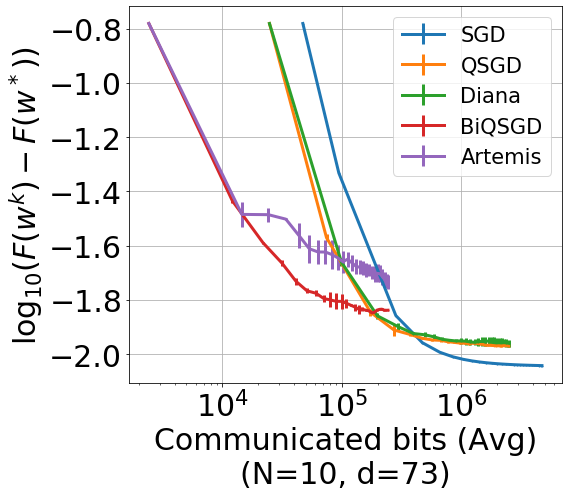

In [18]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, iid)") 


# Without averaging

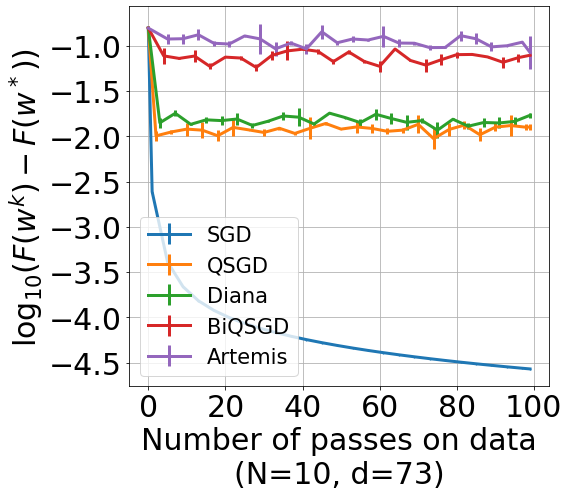

In [19]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_legend="Number of passes on data (iid)", all_error=res.get_std(obj)) 

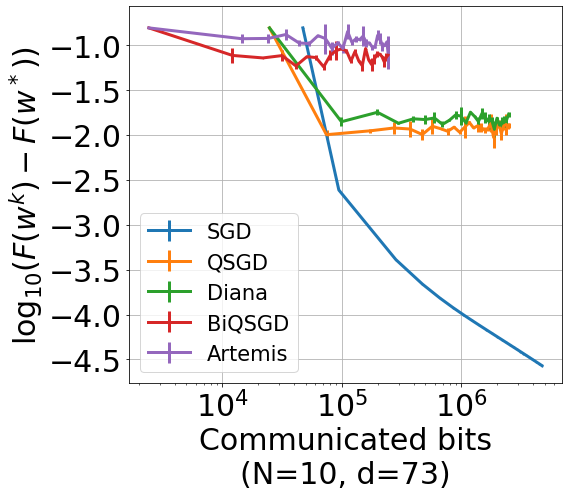

In [20]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (iid)", all_error=res.get_std(obj)) 

# Handling non-iid data

In [21]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = LogisticModel(), 
                                               use_averaging=True, stochastic=False)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 20%|██        | 1/5 [00:16<01:04, 16.00s/it]

QSGD
Large dimension...
Large dimension...


 40%|████      | 2/5 [00:34<00:49, 16.64s/it]

Diana
Large dimension...
Large dimension...


 60%|██████    | 3/5 [00:47<00:31, 15.58s/it]

BiQSGD
Large dimension...
Large dimension...


 80%|████████  | 4/5 [00:55<00:13, 13.43s/it]

Artemis
Large dimension...
Large dimension...


100%|██████████| 5/5 [01:07<00:00, 13.53s/it]

CPU times: user 6min 36s, sys: 1min 3s, total: 7min 40s
Wall time: 1min 7s


# With averaging

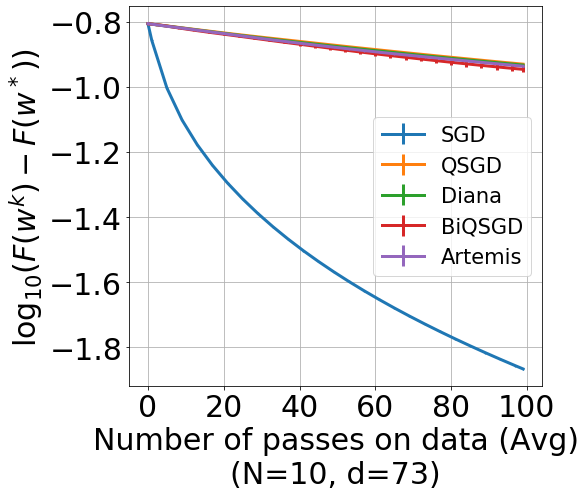

In [22]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
#res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data (Avg)") 

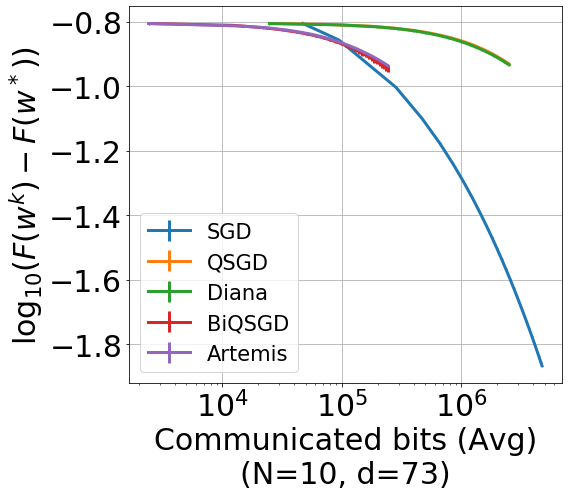

In [23]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

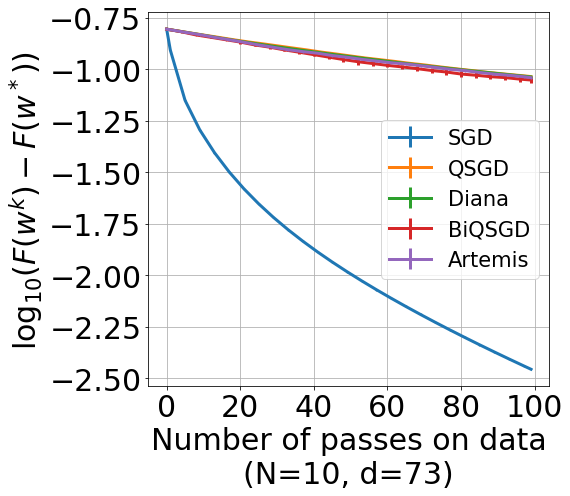

In [24]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
#res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

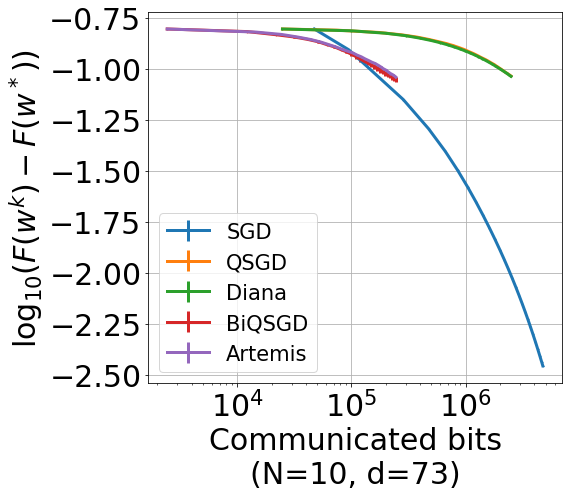

In [25]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 